In [1]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

![](https://cdn.app.compendium.com/uploads/user/a7c086f7-9adb-4d2c-90fa-e26177af8317/7531d8dc-7cb5-440d-9cd9-92d90120c751/File/220ff0c46068005baef585b112ea9040/time_series_forecasting_banner.jpg)

There are different forecasting models like ARMA, ARIMA, Seasonal ARIMA and others. Each model addresses a different type of time series. For this reason, in order to select an appropriate model we need to know something about the data.

In this section we'll learn how to determine if a time series is <em>stationary</em>, if it's <em>independent</em>, and if two series demonstrate <em>correlation</em> and/or <em>causality</em>.

In [2]:
# Load a seasonal dataset
df1 = pd.read_csv('../input/time-series-test/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('../input/time-series-test/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [3]:
df1.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df2.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [5]:
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# Alternative:
# from sklearn.metrics import mean_squared_error

# Stationarity Test

A time series is <em>stationary</em> if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is <em>not</em> stationary.

A test for stationarity usually involves a <a href='https://en.wikipedia.org/wiki/Unit_root_test'>unit root</a> hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller</a> and <a href='https://en.wikipedia.org/wiki/KPSS_test'>Kwiatkowski-Phillips-Schmidt-Shin</a> tests are stationarity tests. 

## Augmented Dickey-Fuller Test

To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

To demonstrate, we'll use a dataset we know is <em>not</em> stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

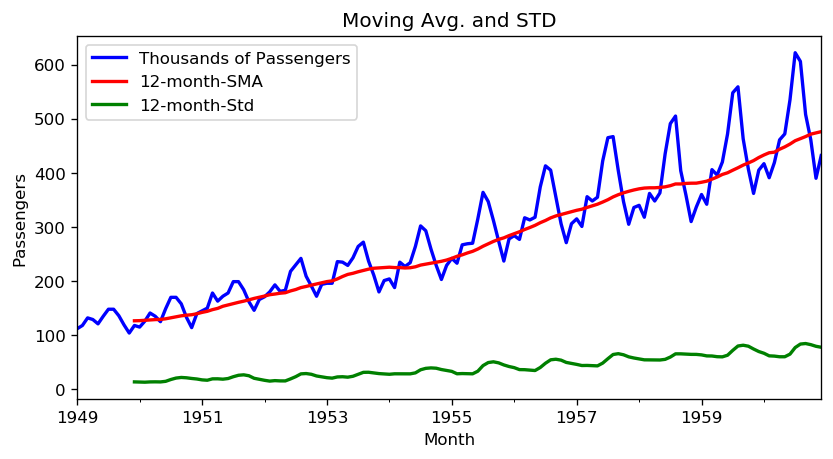

In [6]:
df1['12-month-SMA'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-Std'] = df1['Thousands of Passengers'].rolling(window=12).std()

fig = plt.figure(dpi = 120)
ax = plt.axes()
ax.set(xlabel = 'Month',ylabel = 'Passengers',title = 'Moving Avg. and STD')
df1[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot(figsize = (8,4),lw = 2,ax=ax,color = ['blue','red','green']);

> Not only is this dataset seasonal with a clear upward trend, the standard deviation increases over time as well.

In [7]:
dftest = adfuller(df1['Thousands of Passengers'],autolag='AIC')

print('Augmented Dickey-Fuller Test on Airline Data\n')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Airline Data

ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64


Here we have a very high p-value at 0.99, which provides weak evidence against the null hypothesis, and so we <em>fail to reject</em> the null hypothesis, and decide that our dataset is not stationary.<br>
Note: in statistics we don't "accept" a null hypothesis - nothing is ever truly proven - we just fail to reject it.
<br><br>
Now let's apply the ADF test to stationary data with the Daily Total Female Births dataset.

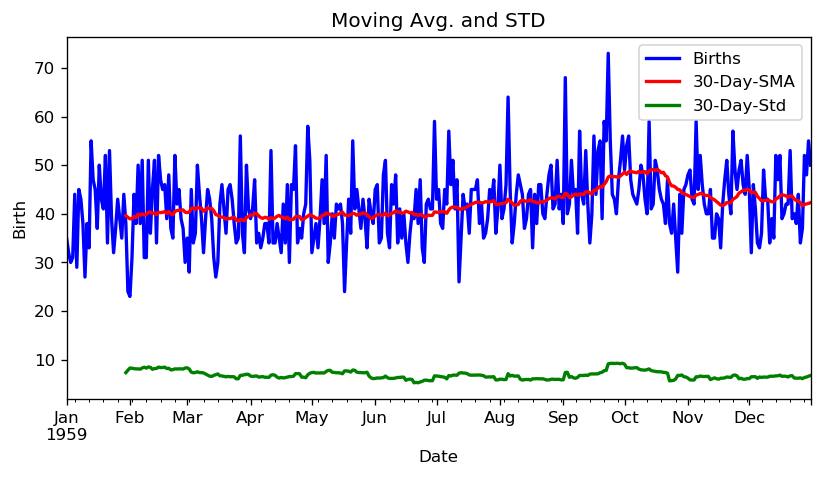

In [8]:
df2['30-Day-SMA'] = df2['Births'].rolling(window=30).mean()
df2['30-Day-Std'] = df2['Births'].rolling(window=30).std()

fig = plt.figure(dpi = 120)
ax = plt.axes()
ax.set(xlabel = 'Date',ylabel = 'Birth',title = 'Moving Avg. and STD')
df2[['Births','30-Day-SMA','30-Day-Std']].plot(figsize = (8,4),lw = 2,ax=ax,color = ['blue','red','green']);

In [9]:
print('Augmented Dickey-Fuller Test on Daily Female Births\n')
dftest = adfuller(df2['Births'],autolag='AIC')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test on Daily Female Births

ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
dtype: float64


In this case our p-value is very low at 0.000052, and we do reject the null hypothesis. This dataset appears to have no unit root, and is stationary.

## Function for running the augmented Dickey-Fuller test

Since we'll use it frequently, let's define a function we can copy into future notebooks for running the augmented Dickey-Fuller test. Remember that we'll still have to import <tt>adfuller</tt> at the top of our notebook.

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
adf_test(df1['Thousands of Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


# Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries

For this example we'll use the samples.csv file, where columns 'a' and 'd' are stationary datasets.

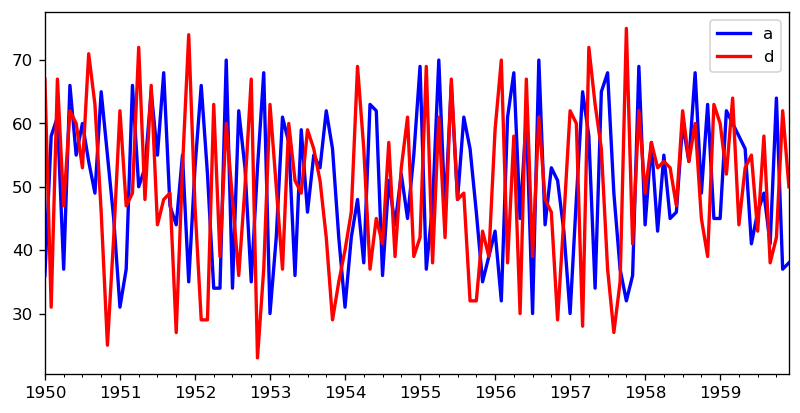

In [14]:
df3 = pd.read_csv('../input/time-series-test/samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'

fig = plt.figure(dpi = 120)
ax = plt.axes()
df3[['a','d']].plot(figsize = (8,4),lw = 2,ax=ax,color = ['blue','red']);

It's hard to tell from this overlay but <tt>df['d']</tt> almost perfectly predicts the behavior of <tt>df['a']</tt>.<br>
To see this more clearly (spoiler alert!), we will shift <tt>df['d']</tt> two periods forward.

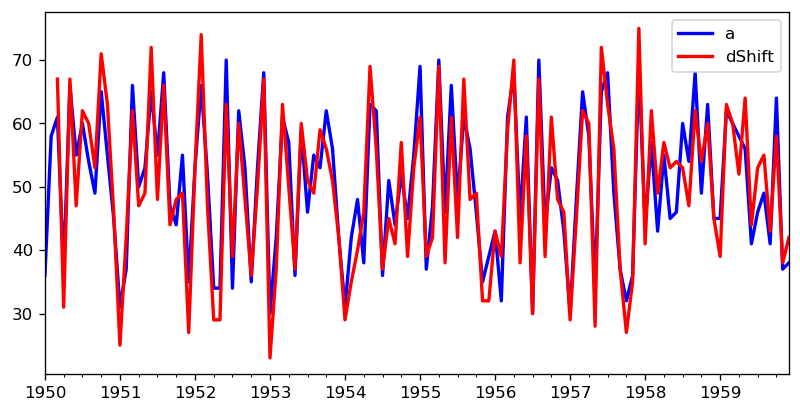

In [15]:
df3['dShift'] = df3['d'].shift(2)

fig = plt.figure(dpi = 120)
ax = plt.axes()
df3[['a','dShift']].plot(figsize = (8,4),lw = 2,ax=ax,color = ['blue','red']);

> We can see that after shifting by 2, D is perfectly explaining time series a, Let us test !!

### Run the test
The function takes in a 2D array [y,x] and a maximum number of lags to test on x. Here our y is column 'a' and x is column 'd'. We'll set maxlags to 3.

In [16]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['a','d']],maxlag=2);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2


Essentially we're looking for extremely low p-values, which we see at lag 2.<br>

By comparison, let's compare two datasets that are not at all similar, 'b' and 'd'.

In [17]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['b','d']],maxlag=2);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2


That's it! P value is not less than 0.05 !!

# Evaluation

Two calculations related to linear regression are <a href='https://en.wikipedia.org/wiki/Mean_squared_error'><strong>mean squared error</strong></a> (MSE) and <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'><strong>root mean squared error</strong></a> (RMSE)

The formula for the mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2$<br><br>
where $T$ is the last observation period and $l$ is the lag point up to $L$ number of test observations.

The formula for the root mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>

The advantage of the RMSE is that it is expressed in the same units as the data.<br><br>

A method similar to the RMSE is the <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'><strong>mean absolute error</strong></a> (MAE) which is the mean of the magnitudes of the error, given as<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.

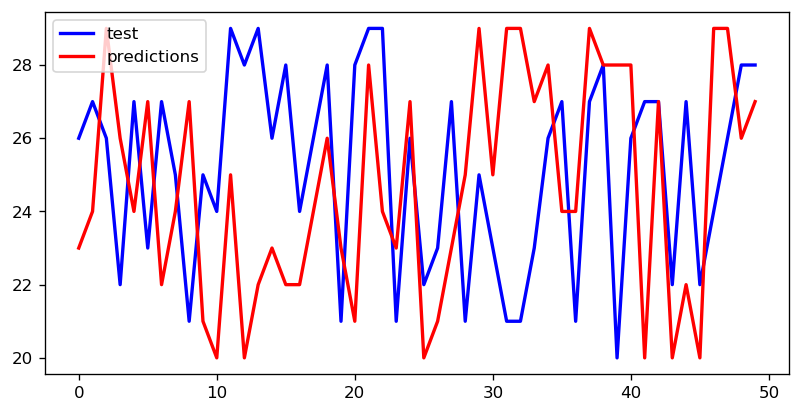

In [18]:
np.random.seed(42)
df = pd.DataFrame(np.random.randint(20,30,(50,2)),columns=['test','predictions'])

fig = plt.figure(dpi = 120)
ax = plt.axes()
df.plot(figsize = (8,4),lw = 2,ax=ax,color = ['blue','red']);

In [19]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs


MSE = mse(df['test'],df['predictions'])
RMSE = rmse(df['test'],df['predictions'])
MAE = meanabs(df['test'],df['predictions'])

print(f'Model  MSE: {MSE:.3f}')
print(f'Model RMSE: {RMSE:.3f}')
print(f'Model  MAE: {MAE:.3f}')

Model  MSE: 17.020
Model RMSE: 4.126
Model  MAE: 3.540


# AIC / BIC

More sophisticated tests include the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'><strong>Akaike information criterion</strong></a> (AIC) and the <a href='https://en.wikipedia.org/wiki/Bayesian_information_criterion'><strong>Bayesian information criterion</strong></a> (BIC).

The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC and BIC, the better the model should be at forecasting.

These functions are available as

&nbsp;&nbsp;&nbsp;&nbsp;<tt>from from statsmodels.tools.eval_measures import aic, bic</tt>

but we seldom compute them alone as they are built into many of the statsmodels tools we use.

# Month and Quarter Plots
Statsmodels has two plotting functions that group data by month and by quarter. Note that if the data appears as months, you should employ <em>resampling</em> with an aggregate function before running a quarter plot. These plots return a <tt>matplotlib.Figure</tt> object.

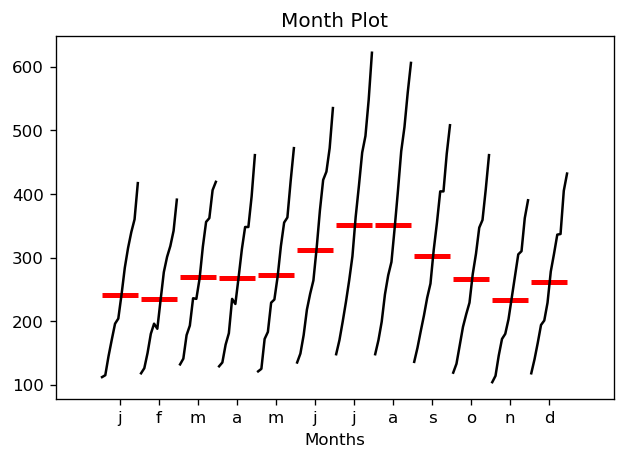

In [20]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

fig = plt.figure(dpi = 120)
ax = plt.axes()
ax.set(xlabel = 'Months',ylabel='Qunatity',title = 'Month Plot')
month_plot(df1['Thousands of Passengers'],ax = ax);

##### We can see there are more people travelling during the summer and vacation june july

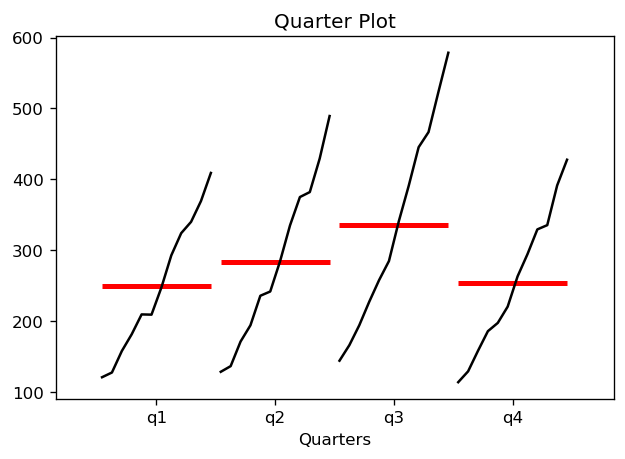

In [21]:
dfq = df1['Thousands of Passengers'].resample(rule='Q').mean()

fig = plt.figure(dpi = 120)
ax = plt.axes()
ax.set(xlabel = 'Quarters',ylabel='Qunatity',title = 'Quarter Plot')


quarter_plot(dfq,ax = ax);

### Great job! I hope you liked it :) Please feel free to suggest anything and give me a feedback. Please up vote my work if you like it !!